In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import seaborn as sns

In [2]:
fq = pd.read_csv('GMDR_FQ.csv')
plots = gpd.read_file('Point_ge.shp')
anpp= pd.read_csv('GMDR_ANPP.csv')
robel= pd.read_csv('GMDR_ROBEL_2021.csv', parse_dates= {"Date1" : ["Year","Month","Date"]})
clips= pd.read_csv('GMDR_ExitClips.csv')
trt= pd.read_csv('GMDR_Treatments.csv')

In [3]:
# Assigne plot IDs based on index values as points were collected in numerical order but some comments were forgotten
plots['PlotID']=plots.index +1

In [4]:
plots.head()

,Comment,geometry,PlotID
0,1,POINT (495340.215 4794407.327),1
1,2,POINT (495352.852 4794408.734),2
2,3,POINT (495361.914 4794410.222),3
3,4,POINT (495339.904 4794399.597),4
4,5,POINT (495350.957 4794398.789),5


# ANPP

Create list of columns for smaller anpp table

In [5]:
anppcols=['Date', 'Year', 'Drought', 'Grazing', 'PlotID', 'C3P(g)', 'C4P(g)', 
      'Forb(g)','Standing Dead(g)', 'Vulpia(g)', 'Bromus(g)', 'Area clipped (m2)']
anpp=anpp[anppcols]

In [6]:
# Convert NaN values to the string 'nan' in order to be able to interpret with dictionary below
anpp['Date'][anpp['Date'].isna()]= 'nan'
anpp['Date'][anpp['Date']=='nan']

108    nan
109    nan
110    nan
111    nan
112    nan
      ... 
211    nan
212    nan
213    nan
214    nan
215    nan
Name: Date, Length: 108, dtype: object

In [7]:
# Figure out which values occur in the date column
pd.unique(anpp.Date)

array(['July, 2019', 'nan', '7/28/2020', '7/29/2020', '7/30/2020',
       '7/27/2021'], dtype=object)

In [8]:
# Make a nested dictionary relating date values to what they should be
datedict={
    2018: {'nan': '7/27/2018'},
    2019: {'July, 2019': '7/24/2019'},
    2020: {'7/28/2020': '7/28/2020',
           '7/29/2020': '7/28/2020',
           '7/30/2020': '7/28/2020'},
    2021: {'7/27/2021': '7/27/2021'},
          }

In [9]:
# Overwrite Date column using dictionary and lambda function
anpp['Date']= anpp.apply(lambda row: datedict[row.Year][row.Date] if row.Year in datedict.keys() else row.Date, 
                            axis=1)

# Convert Date column to datetime data type
anpp['Date']= pd.to_datetime(anpp['Date'])

Create a list of columns (biomass categories) to be added together

In [10]:
#Create a list of columns (biomass categories) to be added together for total biomass 
plants=['C3P(g)', 'C4P(g)', 'Forb(g)','Standing Dead(g)', 'Vulpia(g)', 'Bromus(g)']

Vulpia and Brome are type object not float64

In [11]:
# Look at sorted Vulpia data to assess why it is not a float
anpp['Vulpia(g)'].sort_values(ascending=False)


132       ?
157       ?
247    1.13
182     0.9
154     0.7
       ... 
33        0
252       0
431       0
146     NaN
158     NaN
Name: Vulpia(g), Length: 432, dtype: object

In [12]:
# Look at sorted Bromus data to assess why it is not a float
anpp['Bromus(g)'].sort_values(ascending=False)

132       ?
118    9.45
1       7.6
355    5.91
119    5.85
       ... 
305       0
306       0
431       0
146     NaN
158     NaN
Name: Bromus(g), Length: 432, dtype: object

Replace the 2 records of Vulpia and 1 of Bromus equal to ? with 0. and set series to float datatype

In [13]:
anpp['Vulpia(g)'].replace('?','0', inplace=True)
anpp['Vulpia(g)']=anpp['Vulpia(g)'].astype('float64')

anpp['Bromus(g)'].replace('?','0', inplace=True)
anpp['Bromus(g)']=anpp['Vulpia(g)'].astype('float64')

Remove 2018- from plot IDS

In [14]:
anpp[anpp.PlotID.str.startswith('2018-')].head()

,Date,Year,Drought,Grazing,PlotID,C3P(g),C4P(g),Forb(g),Standing Dead(g),Vulpia(g),Bromus(g),Area clipped (m2)
108,2018-07-27,2018,75,HHMMM,2018-1,2.40,3.45,0.80,0.55,0.01,0.01,0.1
109,2018-07-27,2018,75,HHMMM,2018-1,1.15,5.00,1.15,1.35,0.00,0.00,0.1
110,2018-07-27,2018,99,HHMMM,2018-2,2.20,4.85,5.80,1.15,0.05,0.05,0.1
111,2018-07-27,2018,99,HHMMM,2018-2,23.90,0.00,0.15,4.45,0.00,0.00,0.1
112,2018-07-27,2018,1,HHMMM,2018-3,3.80,3.25,6.15,1.90,0.20,0.20,0.1


In [15]:
# Create lambda function that removes 2018 from PlotID.  It splits PlotID into a tuple and takes the second value [1]
anpp['PlotID']= anpp.apply(lambda row: row['PlotID'].split('-')[1] if row['PlotID'].startswith('2018-') else
                            row['PlotID'], axis=1)


Sum biomass of forage quality types and put in new column, divide by 0.05 for g per m2

In [16]:
anpp['PlotID']=pd.to_numeric(anpp['PlotID'], downcast = 'integer')

In [17]:
anpp['Mass (g)']= anpp[plants].sum(axis=1) #   df['Sum'] = df[col_list].sum(axis=1)

In [18]:
anpp['g/m2']=anpp['Mass (g)']/anpp['Area clipped (m2)']

In [19]:
anpp['Date'].unique()

array(['2019-07-24T00:00:00.000000000', '2018-07-27T00:00:00.000000000',
       '2020-07-28T00:00:00.000000000', '2021-07-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

# fq

In [20]:
# Make a list of just the columns we want
fqcol = ['DateCollected', 'Year', 'Drought', 'Grazing', 'PlotID', 'g/m2', 'Mass (g)', 'Area clipped (m2)']
fq = fq[fqcol]

In [21]:
fq.head()

,DateCollected,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2)
0,5/27/2019,2019,1,HHMMM,3,155.6,7.78,0.05
1,5/27/2019,2019,1,MLLMM,9,35.4,1.77,0.05
2,5/27/2019,2019,1,MMMMM,17,168.8,8.44,0.05
3,5/27/2019,2019,1,HHMMM,23,60.0,3.00,0.05
4,5/27/2019,2019,1,MMMMM,25,46.2,2.31,0.05


Change name of DateCollected column to Date

In [22]:
fq.rename(columns={'DateCollected': 'Date'}, inplace=True)

In [23]:
#Make Date a Datetime datatype
fq['Date']=pd.to_datetime(fq['Date'])
#fq['Drought']=pd.to_numeric(fq['Drought'], downcast = 'integer')

In [24]:
fq[(fq['Year']== 2021)]

,Date,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2)
236,2021-06-01,2021,75,HHMMM,1,55.6,5.56,0.100
237,2021-06-01,2021,99,HHMMM,2,64.1,6.41,0.100
238,2021-06-01,2021,1,HHMMM,3,75.7,7.57,0.100
239,2021-06-01,2021,2,HHMMM,4,88.4,8.84,0.100
240,2021-06-01,2021,50,HHMMM,5,86.5,8.65,0.100
...,...,...,...,...,...,...,...,...
361,2021-07-01,2021,25,HHMMM,24,21.8,1.09,0.050
362,2021-07-01,2021,99,MLLMM,31,32.6,1.63,0.050
363,2021-07-01,2021,2,MLLMM,36,92.0,4.60,0.050
364,2021-07-01,2021,99,HHMMM,47,30.8,0.77,0.025


In [25]:
fq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               366 non-null    datetime64[ns]
 1   Year               366 non-null    int64         
 2   Drought            366 non-null    int64         
 3   Grazing            366 non-null    object        
 4   PlotID             366 non-null    int64         
 5   g/m2               366 non-null    float64       
 6   Mass (g)           366 non-null    float64       
 7   Area clipped (m2)  366 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 23.0+ KB


In [26]:
anpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               432 non-null    datetime64[ns]
 1   Year               432 non-null    int64         
 2   Drought            432 non-null    int64         
 3   Grazing            432 non-null    object        
 4   PlotID             432 non-null    int8          
 5   C3P(g)             430 non-null    float64       
 6   C4P(g)             430 non-null    float64       
 7   Forb(g)            430 non-null    float64       
 8   Standing Dead(g)   430 non-null    float64       
 9   Vulpia(g)          430 non-null    float64       
 10  Bromus(g)          430 non-null    float64       
 11  Area clipped (m2)  432 non-null    float64       
 12  Mass (g)           432 non-null    float64       
 13  g/m2               432 non-null    float64       
dtypes: datetim

combine (append) anpp to fq ne dataframe should have 366 + 432 = 798 rows

In [27]:
fq1=pd.concat([fq,anpp], ignore_index=True, join='inner')

In [28]:
fq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               798 non-null    datetime64[ns]
 1   Year               798 non-null    int64         
 2   Drought            798 non-null    int64         
 3   Grazing            798 non-null    object        
 4   PlotID             798 non-null    int64         
 5   g/m2               798 non-null    float64       
 6   Mass (g)           798 non-null    float64       
 7   Area clipped (m2)  798 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 50.0+ KB


In [29]:
fq1[1:4]

,Date,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2)
1,2019-05-27,2019,1,MLLMM,9,35.4,1.77,0.05
2,2019-05-27,2019,1,MMMMM,17,168.8,8.44,0.05
3,2019-05-27,2019,1,HHMMM,23,60.0,3.00,0.05


In [30]:
fq1.sort_values(by= 'Date', inplace= True)

In [31]:
dates=fq1['Date'].unique()
dates

array(['2018-07-27T00:00:00.000000000', '2019-05-27T00:00:00.000000000',
       '2019-06-24T00:00:00.000000000', '2019-07-24T00:00:00.000000000',
       '2020-06-02T00:00:00.000000000', '2020-06-11T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-07-04T00:00:00.000000000', '2020-07-28T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-06-02T00:00:00.000000000',
       '2021-06-03T00:00:00.000000000', '2021-06-28T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-07-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [32]:
Events = pd.DataFrame({"Date":dates, "Period":['LJuly2018', 'LMay2019', 'LJune2019', 'LJuly2019', 'LMay2020', 'LMay2020', 'LJune2020', 
                                               'LJune2020', 'LJune2020', 'LJuly2020', 'LMay2021', 'LMay2021', 'LMay2021', 'LJune2021', 
                                               'LJune2021', 'LJuly2021']})
Events

,Date,Period
0,2018-07-27,LJuly2018
1,2019-05-27,LMay2019
2,2019-06-24,LJune2019
3,2019-07-24,LJuly2019
4,2020-06-02,LMay2020
5,2020-06-11,LMay2020
6,2020-06-30,LJune2020
7,2020-07-01,LJune2020
8,2020-07-04,LJune2020
9,2020-07-28,LJuly2020


In [33]:
fq=pd.merge(fq1, Events, on = 'Date')

In [34]:
fq

,Date,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2),Period
0,2018-07-27,2018,99,MMMMM,28,61.0,6.10,0.1,LJuly2018
1,2018-07-27,2018,99,MLLMM,40,192.3,19.23,0.1,LJuly2018
2,2018-07-27,2018,1,MLLMM,39,231.0,23.10,0.1,LJuly2018
3,2018-07-27,2018,1,MLLMM,39,159.5,15.95,0.1,LJuly2018
4,2018-07-27,2018,75,MLLMM,38,127.5,12.75,0.1,LJuly2018
...,...,...,...,...,...,...,...,...,...
793,2021-07-27,2021,25,MMMMM,16,42.4,4.24,0.1,LJuly2021
794,2021-07-27,2021,2,MMMMM,15,64.1,6.41,0.1,LJuly2021
795,2021-07-27,2021,2,MMMMM,15,47.0,4.70,0.1,LJuly2021
796,2021-07-27,2021,2,HHMMM,20,40.2,4.02,0.1,LJuly2021


In [35]:
fq[(fq['Period'] == 'LMay2021') & (fq['PlotID']== 19)]


,Date,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2),Period
565,2021-06-01,2021,50,HHMMM,19,44.7,4.47,0.10,LMay2021
621,2021-06-03,2021,50,HHMMM,19,39.2,1.96,0.05,LMay2021


In [36]:
fq[(fq['Period'] == 'LMay2021')]

,Date,Year,Drought,Grazing,PlotID,g/m2,Mass (g),Area clipped (m2),Period
560,2021-06-01,2021,25,HHMMM,24,44.6,4.46,0.10,LMay2021
561,2021-06-01,2021,1,HHMMM,23,48.4,4.84,0.10,LMay2021
562,2021-06-01,2021,25,MMMMM,16,60.4,6.04,0.10,LMay2021
563,2021-06-01,2021,99,HHMMM,21,24.8,2.48,0.10,LMay2021
564,2021-06-01,2021,2,HHMMM,20,58.4,5.84,0.10,LMay2021
...,...,...,...,...,...,...,...,...,...
622,2021-06-03,2021,99,MMMMM,18,61.2,3.06,0.05,LMay2021
623,2021-06-03,2021,25,MLLMM,12,56.8,2.84,0.05,LMay2021
624,2021-06-03,2021,1,MLLMM,9,47.4,2.37,0.05,LMay2021
625,2021-06-03,2021,1,HHMMM,23,71.8,3.59,0.05,LMay2021


In [42]:
#Use groupby to add together the Masses and Areas for all records with the same plotID and Period
fqsum=fq.groupby(['Year', 'PlotID', 'Period']).agg({'Mass (g)': 'sum', 'Area clipped (m2)': 'sum'})
fqsum.reset_index(inplace = True)
fqsum


,Year,PlotID,Period,Mass (g),Area clipped (m2)
0,2018,1,LJuly2018,15.87,0.200
1,2018,2,LJuly2018,42.60,0.200
2,2018,3,LJuly2018,30.00,0.200
3,2018,4,LJuly2018,22.92,0.200
4,2018,5,LJuly2018,42.70,0.200
...,...,...,...,...,...
535,2021,53,LJune2021,7.74,0.100
536,2021,53,LMay2021,9.72,0.100
537,2021,54,LJuly2021,3.99,0.200
538,2021,54,LJune2021,5.06,0.175


In [43]:
fqsum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               540 non-null    int64  
 1   PlotID             540 non-null    int64  
 2   Period             540 non-null    object 
 3   Mass (g)           540 non-null    float64
 4   Area clipped (m2)  540 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 21.2+ KB


In [44]:
fqsum.head()

,Year,PlotID,Period,Mass (g),Area clipped (m2)
0,2018,1,LJuly2018,15.87,0.2
1,2018,2,LJuly2018,42.60,0.2
2,2018,3,LJuly2018,30.00,0.2
3,2018,4,LJuly2018,22.92,0.2
4,2018,5,LJuly2018,42.70,0.2


In [45]:
fqsum[fqsum['PlotID']== 36]

,Year,PlotID,Period,Mass (g),Area clipped (m2)
35,2018,36,LJuly2018,15.25,0.20
159,2019,36,LJuly2019,5.47,0.10
160,2019,36,LJune2019,3.20,0.05
161,2019,36,LMay2019,3.28,0.05
321,2020,36,LJuly2020,9.94,0.20
322,2020,36,LJune2020,4.14,0.10
323,2020,36,LMay2020,3.60,0.05
483,2021,36,LJuly2021,2.85,0.20
484,2021,36,LJune2021,9.09,0.15
485,2021,36,LMay2021,5.67,0.10


In [46]:
#calculate g/m2 by dividing mass by area
fqsum['g/m2'] = fqsum['Mass (g)'] / fqsum['Area clipped (m2)']

In [58]:
# add in treatments by merging with trt dataframe
fqsum=pd.merge(fqsum, trt)
fqsum.head()

,Year,PlotID,Period,Mass (g),Area clipped (m2),g/m2,Site,Block,Paddock,Plot,Drought,Grazing
0,2018,1,LJuly2018,15.87,0.20,79.35,TB,1,2,1,75,HHMMM
1,2019,1,LJuly2019,13.25,0.10,132.50,TB,1,2,1,75,HHMMM
2,2019,1,LJune2019,7.55,0.05,151.00,TB,1,2,1,75,HHMMM
3,2019,1,LMay2019,5.83,0.05,116.60,TB,1,2,1,75,HHMMM
4,2020,1,LJuly2020,16.40,0.20,82.00,TB,1,2,1,75,HHMMM


<AxesSubplot:xlabel='Year', ylabel='g/m2'>

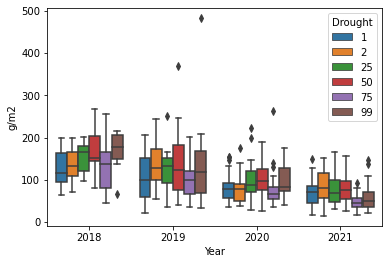

In [54]:
#evaluate fqsum
sns.boxplot(x='Year',y='g/m2', hue= 'Drought', data=fqsum)
#data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean())

C:\Users\John\miniconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

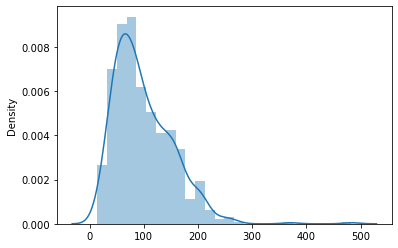

In [55]:
#evaluate fqsum
sns.distplot(x=fqsum['g/m2'])
#data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean())

<AxesSubplot:xlabel='Year', ylabel='g/m2'>

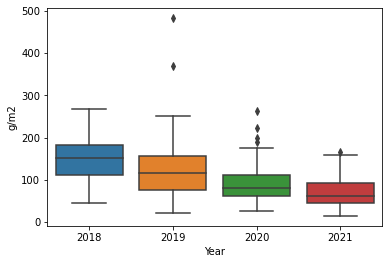

In [56]:
#evaluate fqsum
sns.boxplot(x='Year',y='g/m2', data=fqsum)
#data=robelclip.groupby(['Block', 'Paddock', 'Year']).mean())

In [59]:
#convert to wide format
fqwide= pd.pivot(fqsum, index=['PlotID', 'Drought', 'Grazing'], columns='Period', values='g/m2')

In [60]:
#conver to wide format
#fqwide= pd.pivot(fqsum, index=['PlotID'], columns='Period', values='g/m2')

In [60]:
fqwide.reset_index(inplace = True)

In [62]:
fqwide

Period,PlotID,Drought,Grazing,LJuly2018,LJuly2019,LJuly2020,LJuly2021,LJune2019,LJune2020,LJune2021,LMay2019,LMay2020,LMay2021
0,1,75,HHMMM,79.35,132.5,82.00,36.40,151.000000,140.0,81.400000,116.6,76.0,55.600000
1,2,99,HHMMM,213.00,166.5,115.85,36.90,35.000000,76.2,66.000000,209.4,150.6,64.100000
2,3,1,HHMMM,150.00,64.8,99.35,149.00,108.000000,77.8,105.600000,155.6,72.4,75.700000
3,4,2,HHMMM,114.60,89.6,51.45,79.60,206.600000,90.4,94.000000,200.2,83.2,88.400000
4,5,50,HHMMM,213.50,98.5,85.50,75.60,370.600000,97.4,125.300000,156.8,99.6,86.500000
5,6,25,HHMMM,119.75,112.2,115.85,99.00,164.200000,109.6,125.800000,120.0,120.2,85.700000
6,7,2,MLLMM,109.85,82.2,55.25,22.90,105.800000,120.0,122.800000,112.0,82.0,120.700000
7,8,75,MLLMM,75.60,107.1,58.30,29.45,126.600000,62.4,44.533333,47.2,63.6,59.000000
8,9,1,MLLMM,116.70,146.9,76.95,71.65,56.200000,68.4,84.900000,35.4,59.6,43.866667
9,10,99,MLLMM,150.10,124.7,56.45,20.85,69.200000,77.0,31.428571,71.2,73.0,50.000000


In [63]:
# merge with spatial information
fqs= plots.merge(fqwide, on= 'PlotID')
#country_shapes = country_shapes.merge(country_names, on='iso_a3')

In [64]:
fqs.head(20)

,Comment,geometry,PlotID,Drought,Grazing,LJuly2018,LJuly2019,LJuly2020,LJuly2021,LJune2019,LJune2020,LJune2021,LMay2019,LMay2020,LMay2021
0,1,POINT (495340.215 4794407.327),1,75,HHMMM,79.35,132.5,82.00,36.40,151.0,140.0,81.400000,116.6,76.0,55.600000
1,2,POINT (495352.852 4794408.734),2,99,HHMMM,213.00,166.5,115.85,36.90,35.0,76.2,66.000000,209.4,150.6,64.100000
2,3,POINT (495361.914 4794410.222),3,1,HHMMM,150.00,64.8,99.35,149.00,108.0,77.8,105.600000,155.6,72.4,75.700000
3,4,POINT (495339.904 4794399.597),4,2,HHMMM,114.60,89.6,51.45,79.60,206.6,90.4,94.000000,200.2,83.2,88.400000
4,5,POINT (495350.957 4794398.789),5,50,HHMMM,213.50,98.5,85.50,75.60,370.6,97.4,125.300000,156.8,99.6,86.500000
5,6,POINT (495360.433 4794400.392),6,25,HHMMM,119.75,112.2,115.85,99.00,164.2,109.6,125.800000,120.0,120.2,85.700000
6,7,POINT (495302.865 4794412.510),7,2,MLLMM,109.85,82.2,55.25,22.90,105.8,120.0,122.800000,112.0,82.0,120.700000
7,8,POINT (495313.040 4794415.878),8,75,MLLMM,75.60,107.1,58.30,29.45,126.6,62.4,44.533333,47.2,63.6,59.000000
8,9,POINT (495323.970 4794410.710),9,1,MLLMM,116.70,146.9,76.95,71.65,56.2,68.4,84.900000,35.4,59.6,43.866667
9,10,POINT (495296.100 4794402.982),10,99,MLLMM,150.10,124.7,56.45,20.85,69.2,77.0,31.428571,71.2,73.0,50.000000


<AxesSubplot:>

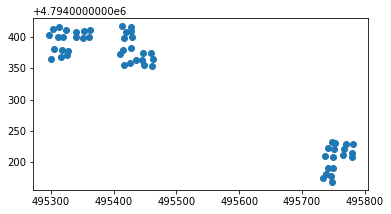

In [65]:
fqs.plot()

In [66]:
fqs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 54 entries, 0 to 53
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Comment    44 non-null     object  
 1   geometry   54 non-null     geometry
 2   PlotID     54 non-null     int64   
 3   Drought    54 non-null     int64   
 4   Grazing    54 non-null     object  
 5   LJuly2018  54 non-null     float64 
 6   LJuly2019  54 non-null     float64 
 7   LJuly2020  54 non-null     float64 
 8   LJuly2021  54 non-null     float64 
 9   LJune2019  54 non-null     float64 
 10  LJune2020  54 non-null     float64 
 11  LJune2021  54 non-null     float64 
 12  LMay2019   54 non-null     float64 
 13  LMay2020   54 non-null     float64 
 14  LMay2021   54 non-null     float64 
dtypes: float64(10), geometry(1), int64(2), object(2)
memory usage: 6.8+ KB


In [68]:
#write to shape file
fqs.to_file('FQspatial.shp')